# response-level_v4.ipynb
## Author: Elliot Pallister

AIM: Obtain response-level feature set for two visual areas across one novel and one familiar image

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Internal imports
from pareto.data_io import get_cache, get_session, get_unit_channels, get_spike_times, get_stimulus_presentations, get_units_by_area, get_trials
from pareto.preprocessing import make_psth_cube, get_image_trials, arrange_image_onsets_to_trial, group_stims_by_frame_index
from pareto.stats import visual_selectivity_filter, subtract_baseline, zscore, roc_analysis, get_snr, population_sparseness, auc_roc


/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Obtaining cache

cache = get_cache()

# Obtaining metadata

ecephys_sessions_table = cache.get_ecephys_session_table()

In [3]:
# Locating novel and familiar session IDs for mouse, based on previous analysis

mouse_id = (ecephys_sessions_table.loc[1044385384])['mouse_id']
mouse_sessions = ecephys_sessions_table[ecephys_sessions_table['mouse_id'] == mouse_id]# 

novel_session_id = mouse_sessions[mouse_sessions['experience_level'] == 'Novel'].index[0]
familiar_session_id = mouse_sessions[mouse_sessions['experience_level'] == 'Familiar'].index[0]

print(novel_session_id)
print(familiar_session_id)

1044594870
1044385384


In [4]:
# Obtaining data from familiar session to begin with

familiar_session = get_session(familiar_session_id)

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
# Obtaining subdata from familiar session

units = get_unit_channels(familiar_session)
trials = get_trials(familiar_session)
stimulus_presentations = get_stimulus_presentations(familiar_session)
spike_times = get_spike_times(familiar_session)

# Obtaining units by visual areas

areas_of_interest = ['VISp', 'VISpm']
area_units = get_units_by_area(units, areas_of_interest)

for area in areas_of_interest:
  print(f"The number of units in {area} are: {area_units['structure_acronym'].value_counts()[area]}")


The number of units in VISp are: 145
The number of units in VISpm are: 223


In [6]:
# Filtering units by quality metrics

quality_unit_filter = ((area_units['snr'] >= 1) & (area_units['isi_violations'] < 1) & (area_units['firing_rate'] > 0.1))
filtered_area_units = area_units.loc[quality_unit_filter].copy()

for area in areas_of_interest:
  print(f"The number of filtered units in {area} are: {filtered_area_units['structure_acronym'].value_counts()[area]}")

The number of filtered units in VISp are: 84
The number of filtered units in VISpm are: 176


In [7]:
image_of_interest = 'im036_r'
image_onsets = stimulus_presentations[stimulus_presentations['image_name'] == image_of_interest]['start_time'].values

print(f"There are {len(image_onsets)} image onsets for {image_of_interest}")

There are 1064 image onsets for im036_r


In [8]:
# Filtering for visually responsive units

selectivity_mask, effect_sizes, p_values = visual_selectivity_filter(filtered_area_units, spike_times, image_onsets, 0.25, 0.5)

filtered_area_units.loc[:, 'effect_size'] = effect_sizes
filtered_area_units.loc[:, 'p_value'] = p_values

visual_area_units = filtered_area_units[selectivity_mask]

for area in areas_of_interest:
  print(f"The number of filtered units in {area} are: {visual_area_units['structure_acronym'].value_counts()[area]}")


ValueError: too many values to unpack (expected 3)

In [ ]:
window_edges = (0.25, 0, 0.25, 0.5)

cube, unit_ids, bins = make_psth_cube(visual_area_units, spike_times, image_onsets, window_edges, bin_size=0.01)
bins = bins[:-1]

print(cube.shape)

(177, 1064, 75)


[ 0 25]


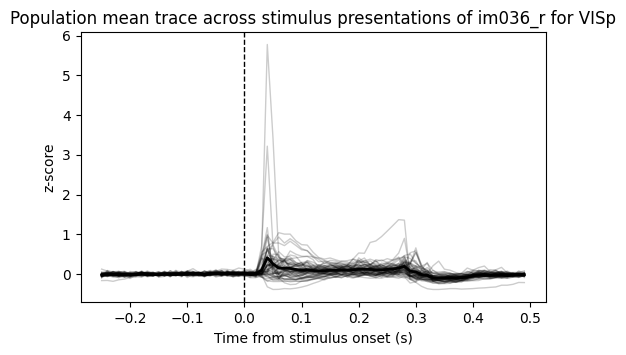

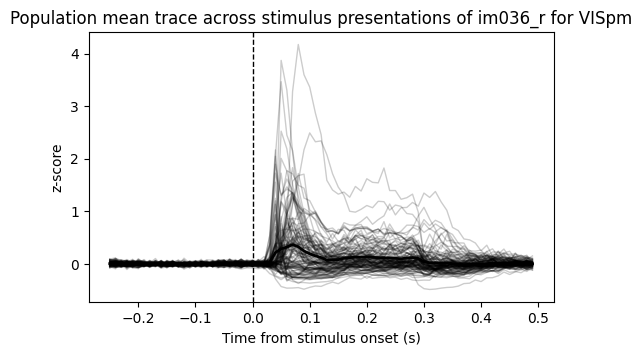

In [ ]:
baseline_window = np.array([-0.25, 0])
baseline_indices = np.searchsorted(bins, baseline_window)
bsub = subtract_baseline(cube, baseline_window, bins)
bsub_rates = bsub / 0.01

baseline_mean = bsub_rates[:,:, baseline_indices[0]:baseline_indices[1]].mean(axis=(1, 2), keepdims=True)
baseline_std = bsub_rates[:,:, baseline_indices[0]:baseline_indices[1]].std(axis=(1, 2), keepdims=True)

zs = (bsub_rates - baseline_mean) / (baseline_std + 1e-9)

zs_mean = zs.mean(axis=1, keepdims=True)

def plot_pop_mean(mu, bins, area):

  mu = np.squeeze(mu)

  fig, ax = plt.subplots(figsize=(6, 3.5))

  for unit_trace in mu:
    ax.plot(bins, unit_trace, color='k', alpha=0.2, lw=1.0, zorder=1)

  pop_mean = mu.mean(axis=0)
  ax.plot(bins, pop_mean, color='k', lw=2.0, zorder=2)

  ax.axvline(0, color='black', linestyle='--', linewidth=1)
  ax.set_xlabel("Time from stimulus onset (s)")
  ax.set_ylabel("z-score")
  ax.set_title(f"Population mean trace across stimulus presentations of im036_r for {area}")

  return fig, ax

for area in areas_of_interest:
  units = np.where(visual_area_units['structure_acronym'] == area)[0]
  zs_mean_area = zs_mean[units, :, :]
  plot_pop_mean(zs_mean_area, bins, area)





In [ ]:
# Obtaining mean evoked response, variance andsignal-to-noise ratio for each unit
evoked_window = (0, 0.25)
evoked_indices = np.searchsorted(bins, evoked_window)
evoked_counts = bsub[:,:,evoked_indices[0]:evoked_indices[1]].sum(axis=2)

feature_vectors = []

for area in areas_of_interest:
  features = []
  units = np.where(visual_area_units['structure_acronym'] == area)[0]
  mean_evoked = evoked_counts[units,:].mean(axis=1)
  variance_evoked = np.var(evoked_counts[units,:], axis=1)
  snrs = mean_evoked / np.sqrt(variance_evoked)
  features.extend([mean_evoked, variance_evoked, snrs])
  feature_vectors.append(features)


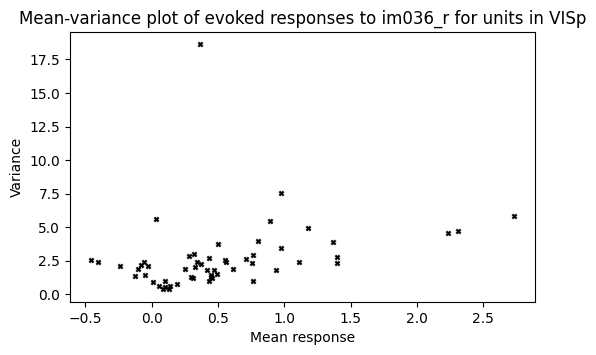

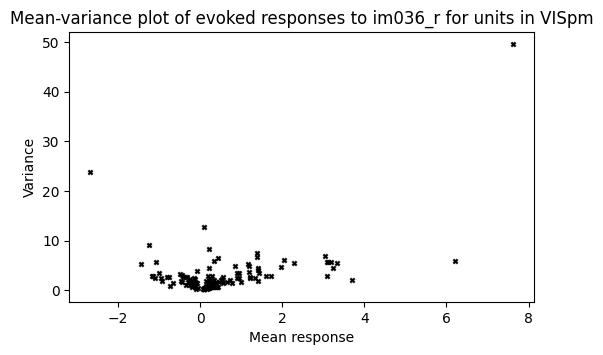

In [ ]:
# Visualising the features

i = 0

for v in feature_vectors:
  means = v[0]
  variances = v[1]

  fig, ax = plt.subplots(figsize=(6, 3.5))
  ax.scatter(means, variances, s=15, c='k', marker='X', linewidths=0.2)
  ax.set_xlabel("Mean response")
  ax.set_ylabel("Variance")
  ax.set_title(f"Mean-variance plot of evoked responses to im036_r for units in {areas_of_interest[i]}")
  i += 1

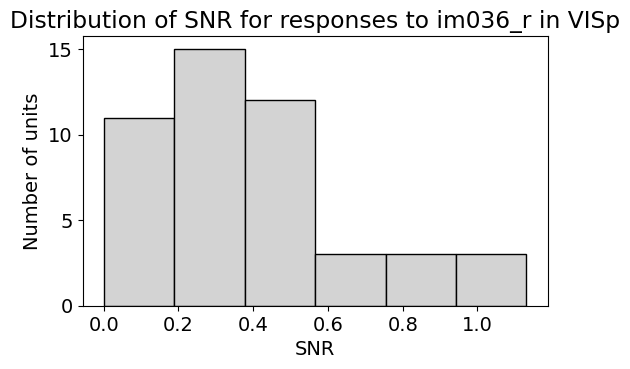

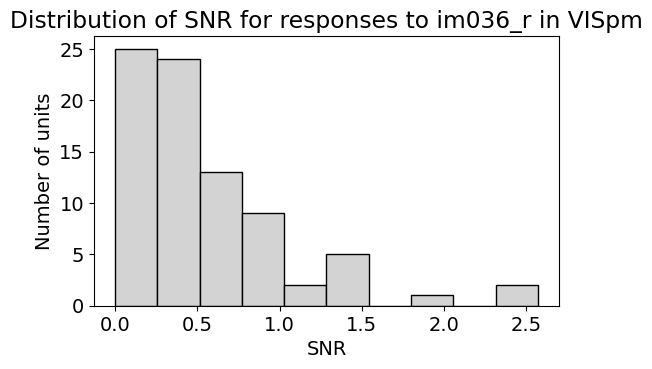

In [ ]:
i = 0

for v in feature_vectors:
  
  snrs = v[2]
  bins_hist = np.linspace(0, max(snrs), int(round(np.sqrt(len(snrs)))))

  fig, ax = plt.subplots(figsize=(6, 3.5))

  ax.hist(snrs, bins_hist, color='lightgrey', edgecolor='black')
  ax.set_xlabel('SNR')
  ax.set_ylabel('Number of units')
  ax.set_title(f"Distribution of SNR for responses to im036_r in {areas_of_interest[i]}")
  i += 1

In [ ]:
# Plotting heatmaps for AUC responses to consecutive trials

area_AUCs = []

for area in areas_of_interest:
  units = np.where(visual_area_units['structure_acronym'] == area)[0]
  _, _, unit_AUCs = auc_roc(evoked_counts[units,:], 20)
  area_AUCs.append(unit_AUCs)

  

/var/folders/pl/1gy_jkhn64jc9d82kg9dl3900000gn/T/ipykernel_75517/2049256426.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
/var/folders/pl/1gy_jkhn64jc9d82kg9dl3900000gn/T/ipykernel_75517/2049256426.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
/var/folders/pl/1gy_jkhn64jc9d82kg9dl3900000gn/T/ipykernel_75517/2049256426.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
/var/folders/pl/1gy_jkhn64jc9d82kg9dl3900000gn/T/ipykernel_75517/2049256426.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

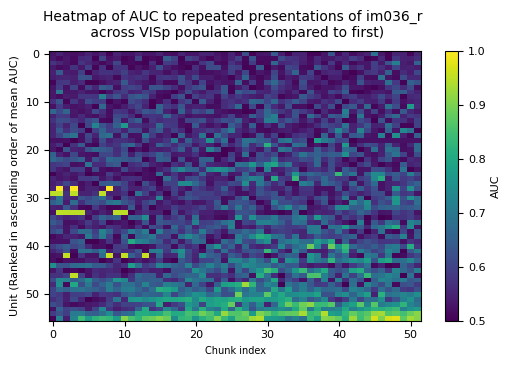

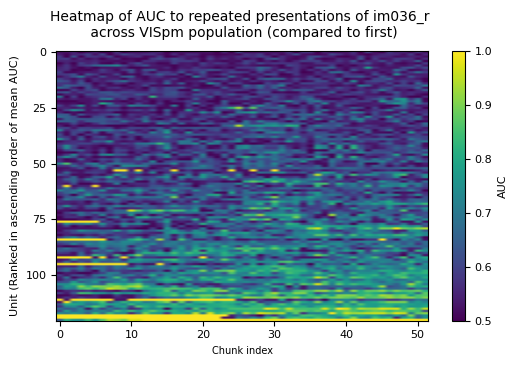

In [ ]:
i = 0

for area in area_AUCs:
  mean_AUCs = area.mean(axis=1)
  ranked_order = np.argsort(mean_AUCs)
  ordered_AUCs = area[ranked_order,:]

  fig, ax = plt.subplots(figsize=(6, 3.5))

  im = ax.imshow(ordered_AUCs, cmap='viridis', aspect='auto')
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label("AUC", fontsize=8)
  cbar.ax.tick_params(labelsize=8)

  ax.set_xlabel("Chunk index", fontsize=7)
  ax.set_ylabel("Unit (Ranked in ascending order of mean AUC)", fontsize=8)
  ax.set_title(f"Heatmap of AUC to repeated presentations of im036_r \n across {areas_of_interest[i]} population (compared to first)", fontsize=10, pad=10)

  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

  i += 1